Install required packages for radar data visualization:

mamba install pyart_mch scikit-image scikit-learn pandas xarray -c conda-forge

pip config --user set global.index-url https://service.meteoswiss.ch/nexus/repository/python-all/simple

pip config --user set global.trusted-host service.meteoswiss.ch

pip install py-radlib

pyart_mch documentation: https://meteoswiss-mdr.github.io/pyart/io.html

Data structure:
* path: /store_new/mch/msrad/radar/swiss/data/
* for dealiased velocity: /store_new/mch/mfeldman/R2D2_YYYY/
* sorted by years, within years in zipped file per day of year
* date notation: YYDDD (days since the beginning of the year, from 001 - 366)
* unzip data you want to work with to your scratch: unzip -d /scratch/mch/fackerma/directoryname MLA21165.zip

File names:
* ??A - Albis radar, ??D - La Dôle, ??L - Monte Lema, ??P - Pointe de la Plaine Morte, ??W - Weissfluhjoch, ??C or ??X - Cartesian composite
* ML? - file with polarimetric radar data
* DV? - dealiased radar data
* CZC - max. reflectivity composite
* RZC - radar-derived rain rate composite
* AZC - radar-derived rain accumulation composite
* VA? - vertical wind profile above radar
* HZC - freezing level height (smoothed from COSMO/ICON)
* MZC - MESHS (maximum expected severe hail size)
* BZC - Probability of hail
* TRTC - thunderstorm radar tracking (very important for your work!)

In [1]:
import pyart
import glob
import numpy as np
import matplotlib.pyplot as plt
import radlib



## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/scratch/mch/mfeldman/miniforge3/envs/jupyter/lib/python3.9/site-packages/pyart/retrieve/ml.py:55: DeprecationWarning: Please import `convolve` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import convolve


In [2]:
def transform_from_digital(mydata, nyquist):
    """
    transforms digital number to velocity

    Parameters
    ----------
    mydata : array
        velocity data as digital number.
    nyquist : float
        nyquist velocity / bounding velocity.

    Returns
    -------
    myfinaldata : array
        velocity data in m/s.

    """
    ##transform digital number to Doppler velocity (MCH)
    myfinaldata = (mydata*1.0 - 128)*nyquist/127
    myfinaldata[mydata==0]=np.nan

    return myfinaldata

In [3]:
path = '/store_new/mch/msrad/mfeldman/case/'
file = glob.glob(path+'ML*23000U.005') # ML File
file2 = glob.glob('/store_new/mch/msrad/mfeldman/case/srn/data/tmp/mof/DVL/*23007L.805') # Dealiased velocity file
file3 = glob.glob(path+'CZC232372300VL.801') # composite file (here reflectivity, but procedure applies to all Cartesian composites)


In [4]:

## How to read ML file and extract data ##
data=pyart.aux_io.read_metranet(file[0],reader='python')
velocity=data.get_field(0,'velocity')
reflectivity=data.get_field(0,'reflectivity').data

## How to read DV file and extract data ##
dv_data = pyart.aux_io.read_file_py(file2[0],physic_value = False)
dv_digital = dv_data.data
dv_header = dv_data.header
nyq=float(dv_header['nyquist'])
dv_velocity = transform_from_digital(dv_digital, nyq)

## How to read Cartesian file and extract data ##
print(file3[0])
#c_data = pyart.aux_io.read_cartesian_metranet(file3[0],reader='python')
c_data = radlib.read_file(file3[0])

czc=c_data.fields['maximum_echo']['data'][0,:,:]


/scratch/mch/mfeldman/miniforge3/envs/jupyter/lib/python3.9/site-packages/pyart/aux_io/metranet_reader.py:829: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  start_time = datetime.datetime.utcfromtimestamp(sweep_start)


/store_new/mch/msrad/mfeldman/case/CZC232372300VL.801


AttributeError: 'tuple' object has no attribute 'tb_frame'

All fields in ML files:
* reflectivity_hh_clut
* spectrum_width
* velocity
* uncorrected_differential_phase
* uncorrected_cross_correlation_ratio
* differential_reflectivity
* reflectivity_vv
* reflectivity
* signal_to_noise_ratio

/tmp/ipykernel_103846/3975078071.py:7: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("plasma").copy()
  cmap.set_bad(color='gray')
/tmp/ipykernel_103846/3975078071.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  p1=plt.pcolormesh(theta, r, reflectivity, vmin=0, vmax=55, cmap=cmap)


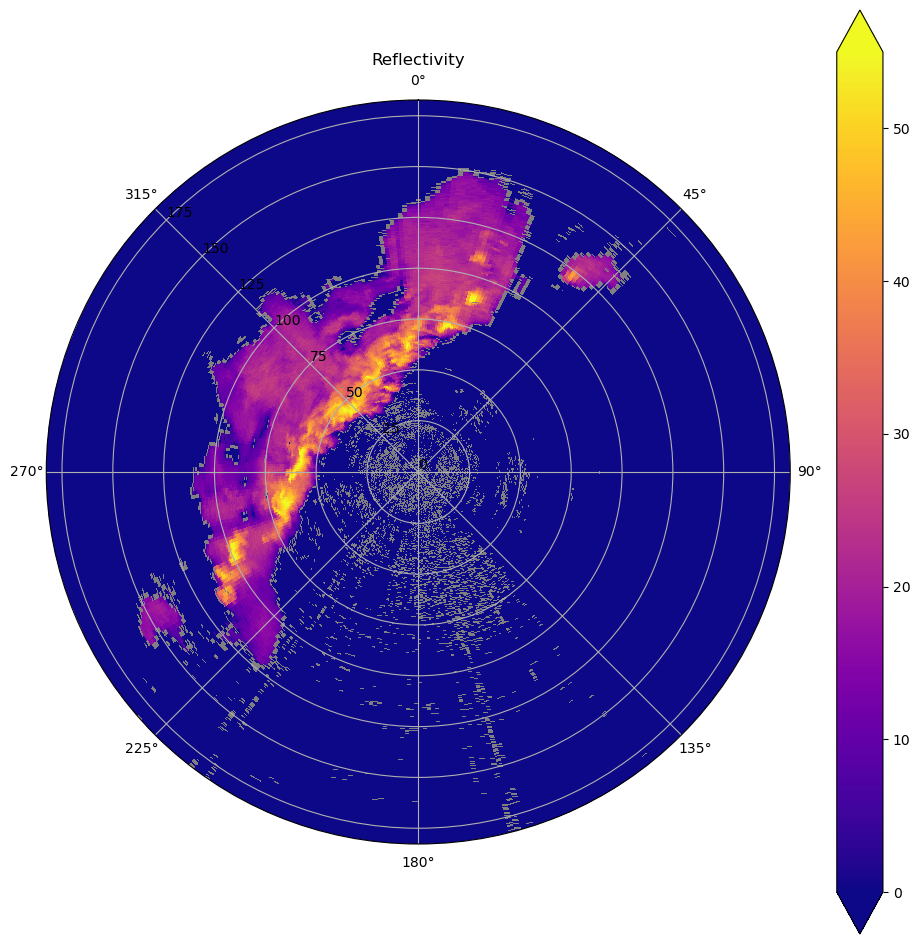

In [5]:
fig=plt.figure(figsize=(12,12))
ax=plt.subplot(1, 1, 1, projection='polar')
ax.set_theta_offset(0.5*np.pi)
ax.set_theta_direction(-1)
ax.set_rlabel_position(315)
cmap=plt.cm.plasma
cmap.set_bad(color='gray')
resolution = 0.5
r, theta = np.meshgrid(np.arange(0, reflectivity.shape[1]*resolution, resolution),np.radians(np.linspace(0, 360, 360)))
p1=plt.pcolormesh(theta, r, reflectivity, vmin=0, vmax=55, cmap=cmap)
plt.colorbar(p1, cmap=cmap, extend='both')
plt.grid()
plt.title('Reflectivity')
#namefig=savepath + imname
plt.show()
#fig.savefig(namefig)
plt.close(fig=fig)

/tmp/ipykernel_103846/736878988.py:7: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("seismic").copy()
  cmap.set_bad(color='gray')
/tmp/ipykernel_103846/736878988.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  p1=plt.pcolormesh(theta, r, velocity, vmin=-15, vmax=15, cmap=cmap)


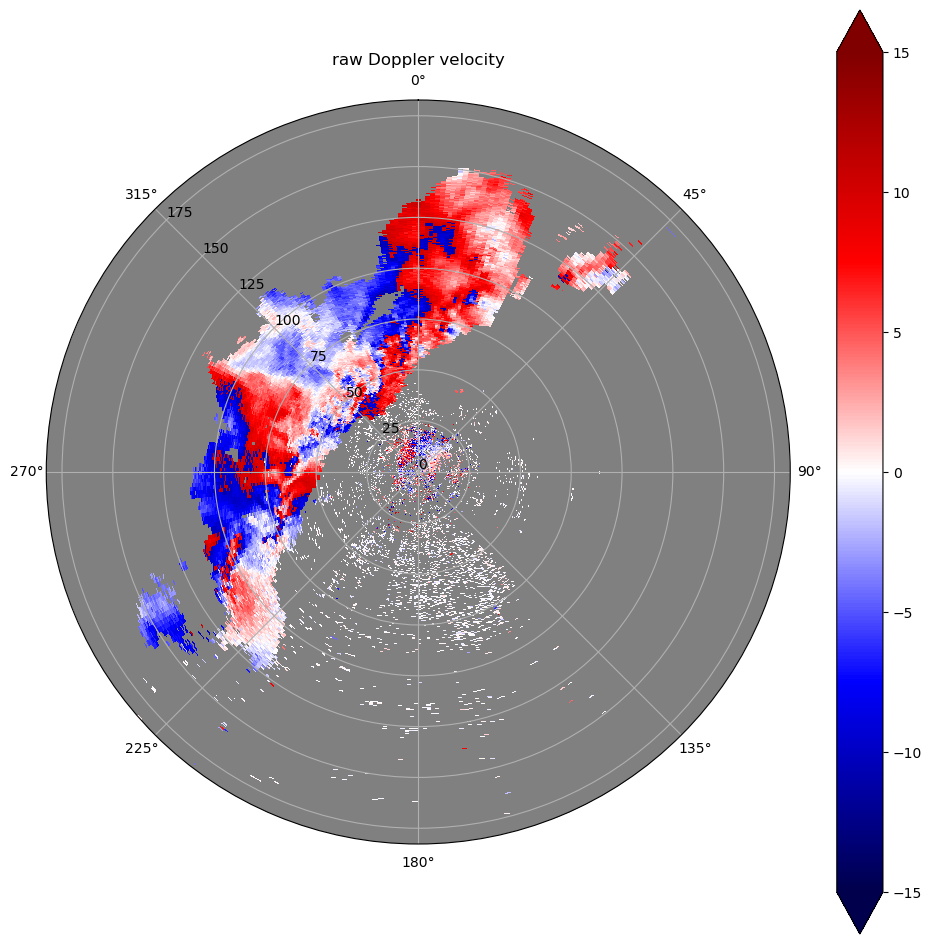

In [6]:
fig=plt.figure(figsize=(12,12))
ax=plt.subplot(1, 1, 1, projection='polar')
ax.set_theta_offset(0.5*np.pi)
ax.set_theta_direction(-1)
ax.set_rlabel_position(315)
cmap=plt.cm.seismic
cmap.set_bad(color='gray')
resolution = 0.5
r, theta = np.meshgrid(np.arange(0, velocity.shape[1]*resolution, resolution),np.radians(np.linspace(0, 360, 360)))
p1=plt.pcolormesh(theta, r, velocity, vmin=-15, vmax=15, cmap=cmap)
plt.colorbar(p1, cmap=cmap, extend='both')
plt.grid()
plt.title('raw Doppler velocity')
#namefig=savepath + imname
plt.show()
#fig.savefig(namefig)
plt.close(fig=fig)

/tmp/ipykernel_103846/3464934212.py:7: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("seismic").copy()
  cmap.set_bad(color='gray')
/tmp/ipykernel_103846/3464934212.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  p1=plt.pcolormesh(theta, r, dv_velocity, vmin=-33, vmax=33, cmap=cmap)


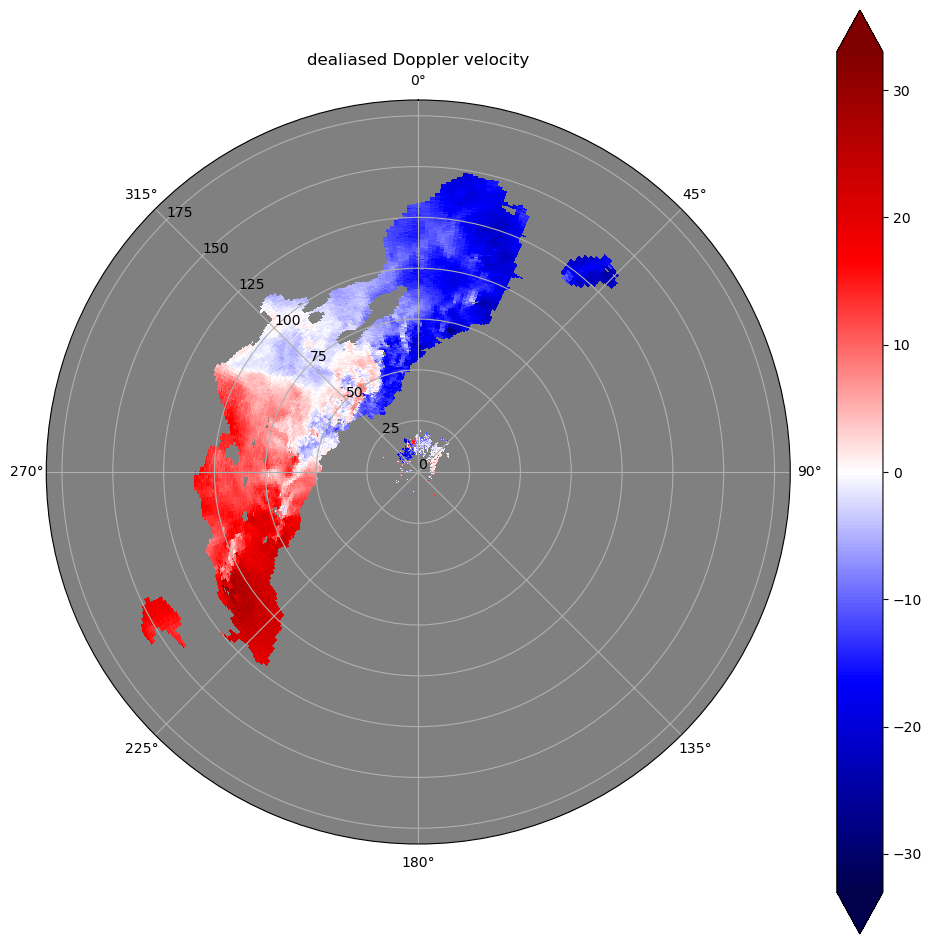

In [7]:
fig=plt.figure(figsize=(12,12))
ax=plt.subplot(1, 1, 1, projection='polar')
ax.set_theta_offset(0.5*np.pi)
ax.set_theta_direction(-1)
ax.set_rlabel_position(315)
cmap=plt.cm.seismic
cmap.set_bad(color='gray')
resolution = 0.5
r, theta = np.meshgrid(np.arange(0, dv_velocity.shape[1]*resolution, resolution),np.radians(np.linspace(0, 360, 360)))
p1=plt.pcolormesh(theta, r, dv_velocity, vmin=-33, vmax=33, cmap=cmap)
plt.colorbar(p1, cmap=cmap, extend='both')
plt.grid()
plt.title('dealiased Doppler velocity')
#namefig=savepath + imname
plt.show()
#fig.savefig(namefig)
plt.close(fig=fig)

/tmp/ipykernel_103846/3350974025.py:4: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("plasma").copy()
  cmap.set_bad(color='gray')


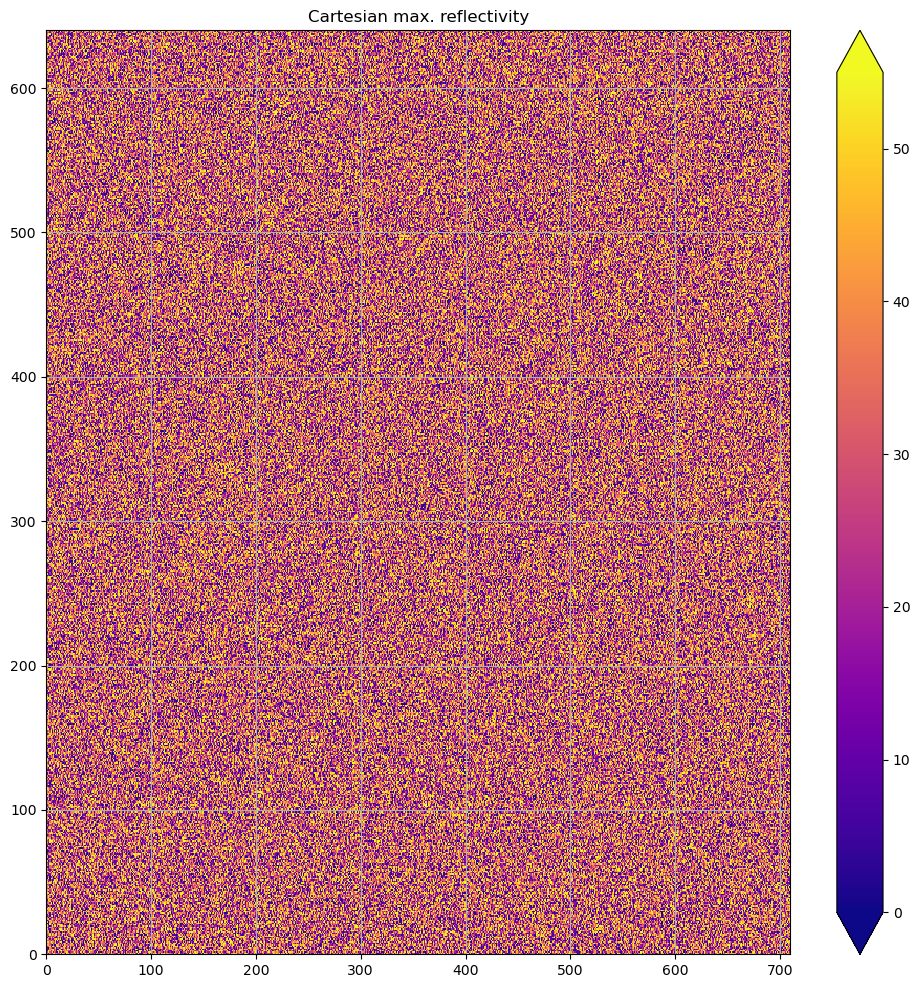

In [8]:
czc = np.random.randint(0,60,size=[640,710])
fig=plt.figure(figsize=(12,12))
cmap=plt.cm.plasma
cmap.set_bad(color='gray')
p1=plt.pcolormesh(czc, vmin=0, vmax=55, cmap=cmap)
plt.colorbar(p1, cmap=cmap, extend='both')
plt.grid()
plt.title('Cartesian max. reflectivity')
#namefig=savepath + imname
plt.show()
#fig.savefig(namefig)
plt.close(fig=fig)